### Context

DRS bank is facing challenging times. Their NPAs (Non-Performing Assets) has been on a rise recently and a large part of these are due to the loans given to individual customers(borrowers). Chief Risk Officer of the bank decides to put in a scientifically robust framework for approval of loans to individual customers to minimize the risk of loans converting into NPAs and initiates a project for the data science team at the bank. You, as a senior member of the team, are assigned this project.

### Objective
To identify the criteria to approve loans for an individual customer such that the likelihood of the loan delinquency is minimized

### Key questions to be answered
What are the factors that drive the behavior of loan delinquency?

### Dataset
* ID: Customer ID
* isDelinquent : indicates whether the customer is delinquent or not (1 => Yes, 0 => No)
* term: Loan term in months
* gender: Gender of the borrower
* age: Age of the borrower
* purpose: Purpose of Loan
* home_ownership: Status of borrower's home
* FICO: FICO (i.e. the bureau score) of the borrower

### Domain Information
* Transactor – A person who pays his due amount balance full and on time.
* Revolver – A person who pays the minimum due amount but keeps revolving his balance and does not pay the full amount.
* Delinquent - Delinquency means that you are behind on payments, a person who fails to pay even the minimum due amount.
* Defaulter – Once you are delinquent for a certain period your lender will declare you to be in the default stage.
* Risk Analytics – A wide domain in the financial and banking industry, basically analyzing the risk of the customer.


In [1]:
#importing necessaary libraries and functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.max_columns", None)

from sklearn.model_selection import train_test_split
from sklearn import tree

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score,
    plot_confusion_matrix,
    precision_recall_curve,
    roc_curve)

### Loading and Overview of dataset

In [2]:
df=pd.read_csv(r'C:\Users\user\Downloads\Loan_Delinquent_Dataset.csv')

In [3]:
data=df.copy(deep=True)

In [4]:
data.head()

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
0,1,1,36 months,Female,House,Mortgage,>25,300-500
1,2,0,36 months,Female,House,Rent,20-25,>500
2,3,1,36 months,Female,House,Rent,>25,300-500
3,4,1,36 months,Female,Car,Mortgage,>25,300-500
4,5,1,36 months,Female,House,Rent,>25,300-500


In [5]:
data.tail()

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
11543,11544,0,60 months,Male,other,Mortgage,>25,300-500
11544,11545,1,36 months,Male,House,Rent,20-25,300-500
11545,11546,0,36 months,Female,Personal,Mortgage,20-25,>500
11546,11547,1,36 months,Female,House,Rent,20-25,300-500
11547,11548,1,36 months,Male,Personal,Mortgage,20-25,300-500


In [6]:
data.sample(5)

,ID,isDelinquent,term,gender,purpose,home_ownership,age,FICO
6927,6928,1,60 months,Male,House,Mortgage,20-25,>500
4119,4120,0,36 months,Male,House,Rent,20-25,>500
8577,8578,0,36 months,Female,House,Rent,>25,>500
7161,7162,1,36 months,Male,Car,Mortgage,20-25,300-500
3340,3341,0,36 months,Female,Wedding,Mortgage,>25,>500


### Shape of dataset

In [7]:
data.shape

(11548, 8)

### Dtypes of dataset

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11548 entries, 0 to 11547
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              11548 non-null  int64 
 1   isDelinquent    11548 non-null  int64 
 2   term            11548 non-null  object
 3   gender          11548 non-null  object
 4   purpose         11548 non-null  object
 5   home_ownership  11548 non-null  object
 6   age             11548 non-null  object
 7   FICO            11548 non-null  object
dtypes: int64(2), object(6)
memory usage: 721.9+ KB


* There are two columns with integer datatype and 6 columns with object datatype
* There are no null values in the dataset
* isDelinquent is the target column

In [9]:
data.isnull().sum()

ID                0
isDelinquent      0
term              0
gender            0
purpose           0
home_ownership    0
age               0
FICO              0
dtype: int64

### Statistical summary

In [10]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,11548.0,5774.500000,3333.764789,1.0,2887.75,5774.5,8661.25,11548.0
isDelinquent,11548.0,0.668601,0.470737,0.0,0.00,1.0,1.00,1.0


In [11]:
col=data.select_dtypes(include='object').columns.tolist()
col

['term', 'gender', 'purpose', 'home_ownership', 'age', 'FICO']

In [12]:
# Printing the value counts for each type in all the categorical columns

for i in col:
    print(data[i].value_counts())
    print('-'*50)
print(data['isDelinquent'].value_counts())

36 months    10589
60 months      959
Name: term, dtype: int64
--------------------------------------------------
Male      6555
Female    4993
Name: gender, dtype: int64
--------------------------------------------------
House       6892
Car         2080
Other        928
Personal     892
Wedding      408
Medical      266
other         82
Name: purpose, dtype: int64
--------------------------------------------------
Mortgage    5461
Rent        5216
Own          871
Name: home_ownership, dtype: int64
--------------------------------------------------
20-25    5888
>25      5660
Name: age, dtype: int64
--------------------------------------------------
300-500    6370
>500       5178
Name: FICO, dtype: int64
--------------------------------------------------
1    7721
0    3827
Name: isDelinquent, dtype: int64


* There are two terms present in the data i.e 36 months and 60 months
* Males and Females both are present in the data
* There are 7 different purposes but there are two 'other' type of purpose, so this needs to be further analysed.
* 3 different types of home ownerships is present
* Two categories of ages is present in data
* There are two categories in the FICO score

### Data preperation

* As the ID is unique for all customers this column can be dropped.

In [13]:
data.drop('ID',axis=1,inplace=True)

* There are two 'other' types in the purpose column so they must be combined or given a different name depending on the data.

In [14]:
data[data['purpose']=='Other']

,isDelinquent,term,gender,purpose,home_ownership,age,FICO
11,1,36 months,Female,Other,Rent,20-25,>500
15,1,36 months,Female,Other,Own,>25,300-500
41,0,36 months,Male,Other,Own,20-25,>500
50,1,36 months,Male,Other,Rent,20-25,300-500
62,1,36 months,Female,Other,Rent,>25,300-500
...,...,...,...,...,...,...,...
11474,1,36 months,Female,Other,Mortgage,>25,300-500
11480,1,36 months,Female,Other,Mortgage,>25,300-500
11483,0,36 months,Male,Other,Mortgage,20-25,300-500
11526,1,36 months,Female,Other,Rent,>25,300-500


In [15]:
data[data['purpose']=='other']

,isDelinquent,term,gender,purpose,home_ownership,age,FICO
401,1,60 months,Male,other,Mortgage,20-25,>500
553,0,60 months,Male,other,Rent,>25,>500
566,1,60 months,Male,other,Mortgage,20-25,>500
707,0,60 months,Male,other,Own,>25,300-500
913,0,60 months,Male,other,Rent,>25,300-500
...,...,...,...,...,...,...,...
10866,1,60 months,Male,other,Rent,20-25,>500
11001,0,60 months,Male,other,Mortgage,>25,>500
11040,0,60 months,Male,other,Mortgage,>25,>500
11430,0,60 months,Male,other,Rent,>25,300-500


In [16]:
data['term'][data['purpose']=='Other'].value_counts()

36 months    928
Name: term, dtype: int64

In [17]:
data['term'][data['purpose']=='other'].value_counts()

60 months    82
Name: term, dtype: int64

* The 'Other' purpose has only terms with 36 months and 'other' purpose has the terms only with 60 months.
* Other than that there is no significant difference.
* They can be combined together or left and continue with the analysis.

In [18]:
df_new=df.copy(deep=True)
df_new['purpose'].replace(to_replace='other',value='Other',inplace=True)
df_new.drop('ID',axis=1,inplace=True)

### Univariate Analysis

In [19]:
# Function to plot the countplot of categorical variables with percentage or 
# the frequency of each type persent in that variable.
 

def barplt(data,cl1,prec=False,n=None):
    total=len(data[cl1])
    count=data[cl1].nunique()
    
    if n is None:
        plt.figure(figsize=(count+1,5))
    else:
        plt.figure(figsize=(n+1,5))
    
    plt.xticks(rotation=90,fontsize=15)
    pt=sns.countplot(data=data,x=cl1,palette='husl',order=data[cl1].value_counts().index[:n].sort_values())
    
    
    for p in pt.patches:
        if prec==True:
            label='{:.1f}%'.format(100*p.get_height()/total)
        else:
            label=p.get_height()
        
        x=p.get_x()+p.get_width()/2
        y=p.get_height()
        
        pt.annotate(label,(x,y),ha='center',va='center',size=12,xytext=(0,5),textcoords='offset points')
    
    plt.show()

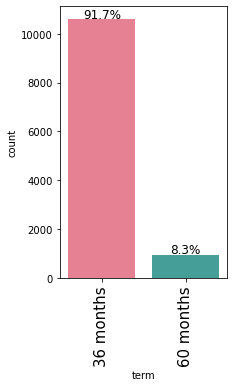

In [20]:
barplt(data,'term',prec=True)

* The term column is highly imbalanced
* 91.7% of the data has term for 36 months

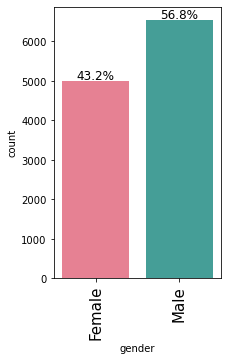

In [21]:
barplt(data,'gender',prec=True)

* There are more males than females. 
* Males are about 56.8%

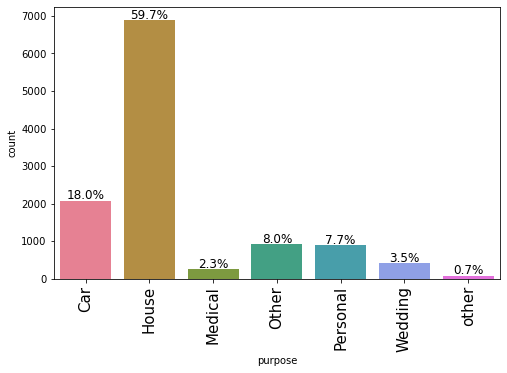

In [22]:
barplt(data,'purpose',prec=True)

* House has the percentage of data followed by car
* If the two 'other' purposes are combined then the Medical has the least percent. 

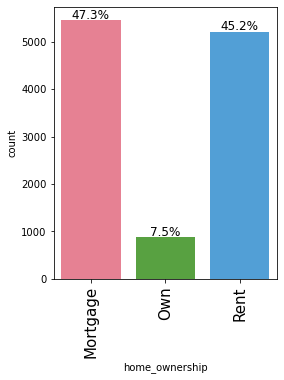

In [23]:
barplt(data,'home_ownership',prec=True)

* Most of the people are still paying the Mortgage or staying in a rented house.
* Very few peole have own house

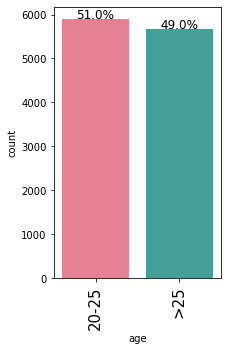

In [24]:
barplt(data,'age',prec=True)

* Almost silimiar percent people are present from both age groups.
* But for the age group 20-25 the interval different is only 5 years but the percentage of people in the data is 51%. So, we can infer that people in age group 20-25 have a higher tendency to take loans.

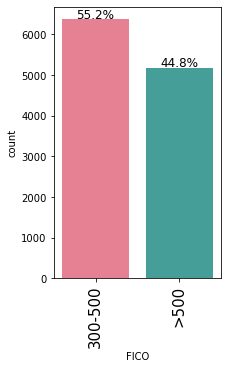

In [25]:
barplt(data,'FICO',prec=True)

* Most people have a FICO score between 300-500 i.e. about 55.2%
* There is also a good percentage of people with score >500

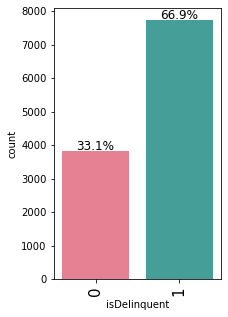

In [26]:
barplt(data,'isDelinquent',prec=True)

* The target column is imbalanced so this is an imbalanced binary classification
* As the percentage of 1 is higher compared to 0 we can say that there are more peoplw who are classified as delinquent compared to non-delinquent.

### Bivariate Analysis

In [27]:
# Function to plot the countplot of a categorical variable with hue as another categorical variable.
# The percent of each type in hue is displayed on the top of bars in the plot.

def countplt(data,cl1,cl2,prec=False):
    
    count=data[cl2].nunique()
    plt.figure(figsize=(count+4,5))
    pt=sns.countplot(data=data,x=cl1,hue=cl2,palette='Paired')

    hei=[]
    wid=[]
    xl=[]
    for p in pt.patches:
        hei.append(p.get_height())
        wid.append(p.get_width())
        xl.append(p.get_x())

    count=0
    for i in range(data[cl2].nunique()):
        for j in range(data[cl1].nunique()):
            if prec==True:
                label='{:.1f}%'.format(100*hei[count]/df[cl2].value_counts(sort=False).values[i])
            else:
                label=hei[count]

            x=xl[count]+wid[count]/2
            y=hei[count]

            pt.annotate(label,(x,y),ha='center',va='center',size=12,xytext=(0,5),textcoords='offset points') 

            count+=1

    plt.show()

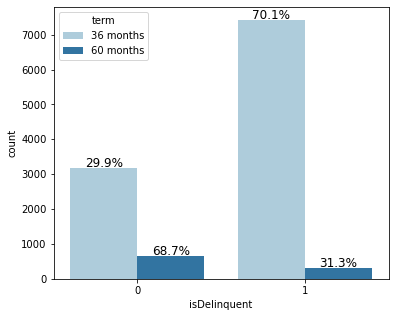

In [28]:
countplt(data,'isDelinquent','term',prec=True)

* For term of 36 months we see that there is higher percent of people who are categorised as delinquent
* For the term 60 months more people were categorised as non-delinquent
* So there is a higher chance for people getting categorized delinquent for term with 36 months compared to that of 60 months.

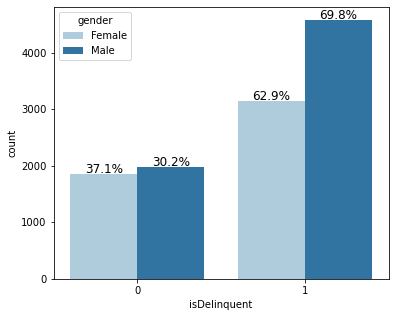

In [29]:
countplt(data,'isDelinquent','gender',prec=True)

* The precent of males being classified as delinquent is slightly higher than that of females.
* But there is good chance that both the genders being classified as delinquent as the percent is high.

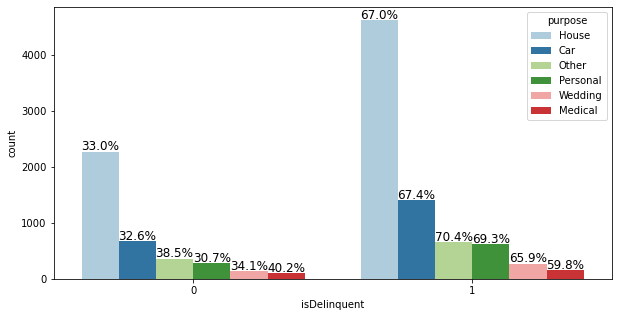

In [30]:
countplt(df_new,'isDelinquent','purpose',prec=True)

* Combined 'Other' purpose has the highest percentage of people that are categorized as delinquent
* Personal purpose also has a high percentage of people in delinquent category.
* House and Car has almost same percent of people in delinquent followed by wedding
* Medical has the least percent of people in delinquent

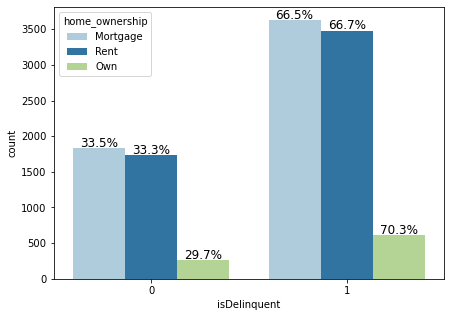

In [31]:
countplt(df_new,'isDelinquent','home_ownership',prec=True)

* There is a high percent of people with own homes in the delinquent category.
* Followed by Mortgage and Rent home_ownership type with almost similar percent of people in delinquent category.

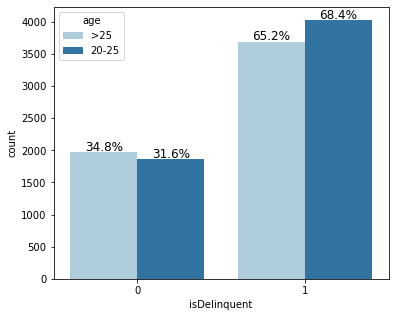

In [32]:
countplt(df_new,'isDelinquent','age',prec=True)

* Both age groups have almost similar percent of people in delinquent category with age 20-25 being slightly higher.
* Given the small interval size of age group 20-25, there is higher chance of being in delinquent category.

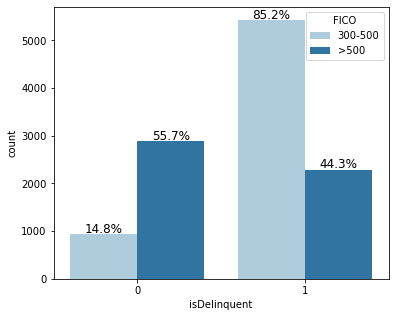

In [33]:
countplt(df_new,'isDelinquent','FICO',prec=True)

* People with FICO score between 300-500 have a very high percentage of people in delinquent category
* People with FICO score >500 has high percent of people in non-delinquent category
* So there is a good chance of people with score >500 to be non-delinquent

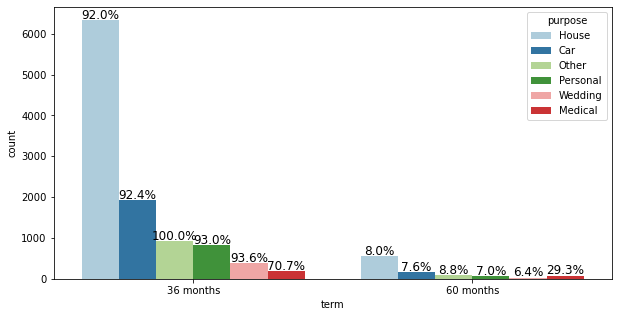

In [34]:
countplt(df_new,'term','purpose',prec=True)

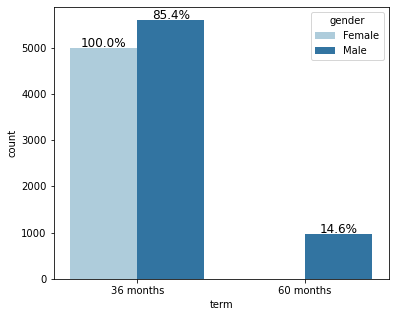

In [35]:
countplt(df_new,'term','gender',prec=True)

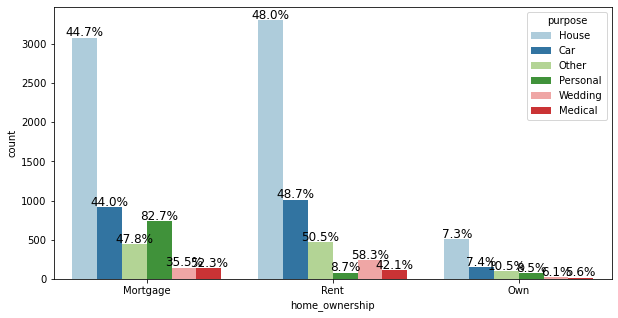

In [36]:
countplt(df_new,'home_ownership','purpose',prec=True)

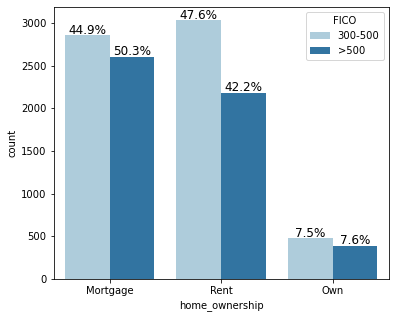

In [37]:
countplt(df_new,'home_ownership','FICO',prec=True)

###  Data Preprocessing

In [38]:
for i in col:
    print(data[i].value_counts())
    print('-'*50)
print(data['isDelinquent'].value_counts())

36 months    10589
60 months      959
Name: term, dtype: int64
--------------------------------------------------
Male      6555
Female    4993
Name: gender, dtype: int64
--------------------------------------------------
House       6892
Car         2080
Other        928
Personal     892
Wedding      408
Medical      266
other         82
Name: purpose, dtype: int64
--------------------------------------------------
Mortgage    5461
Rent        5216
Own          871
Name: home_ownership, dtype: int64
--------------------------------------------------
20-25    5888
>25      5660
Name: age, dtype: int64
--------------------------------------------------
300-500    6370
>500       5178
Name: FICO, dtype: int64
--------------------------------------------------
1    7721
0    3827
Name: isDelinquent, dtype: int64


In [39]:
replaceStr = {
    'term':{'36 months':1,'60 months': 2},
    'age':{'20-25':1,'>25':2},
    'FICO':{'300-500':1,'>500':2}
}

encodingCol = ['gender','purpose','home_ownership']

In [40]:
df_new=df_new.replace(replaceStr)
df_new=pd.get_dummies(df_new,columns=encodingCol,drop_first=True)
df_new.head()

,isDelinquent,term,age,FICO,gender_Male,purpose_House,purpose_Medical,purpose_Other,purpose_Personal,purpose_Wedding,home_ownership_Own,home_ownership_Rent
0,1,1,2,1,0,1,0,0,0,0,0,0
1,0,1,1,2,0,1,0,0,0,0,0,1
2,1,1,2,1,0,1,0,0,0,0,0,1
3,1,1,2,1,0,0,0,0,0,0,0,0
4,1,1,2,1,0,1,0,0,0,0,0,1


In [41]:
X_new=df_new.drop('isDelinquent',axis=1)
y_new=df_new['isDelinquent']

#### Splitting the data into train and test

In [42]:
x_tra,x_tes,y_tra,y_tes=train_test_split(X_new,y_new,test_size=0.3,shuffle=True,random_state=1)

### Model Building

In [43]:
# Function for the evaluation of model performance based on different metrics

def model_performance(model,features,target):
    
    
    pred=model.predict(features)
    
    acc=accuracy_score(target,pred)
    recall=recall_score(target,pred)
    precision=precision_score(target,pred)
    f1=f1_score(target,pred)
    
    df_score = pd.DataFrame({'accuracy':acc,'recall':recall,'precision':precision,'f1_score':f1},index=[0])
    
    return df_score

In [44]:
# Function for plotting the confusion matrix

def confusion_mat(model,features,target,threshold=0.5):
    
    pred=model.predict(features)
    
    cm = confusion_matrix(target, pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [45]:
dt=tree.DecisionTreeClassifier()
dt.fit(x_tra,y_tra)

DecisionTreeClassifier()

#### Model Performance

In [46]:
model_performance(dt,x_tra,y_tra)

,accuracy,recall,precision,f1_score
0,0.852283,0.906571,0.878201,0.89216


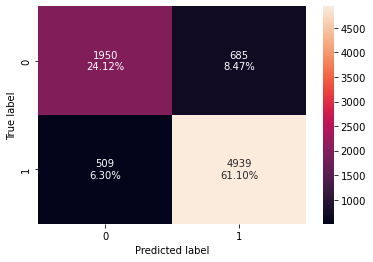

In [47]:
confusion_mat(dt,x_tra,y_tra)

In [48]:
model_performance(dt,x_tes,y_tes)

,accuracy,recall,precision,f1_score
0,0.847042,0.893973,0.875485,0.884632


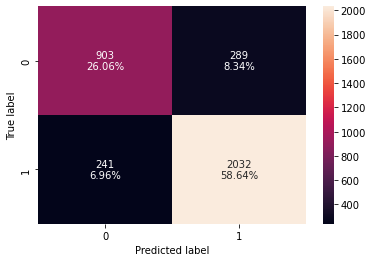

In [49]:
confusion_mat(dt,x_tes,y_tes)

####  Visualisation of tree

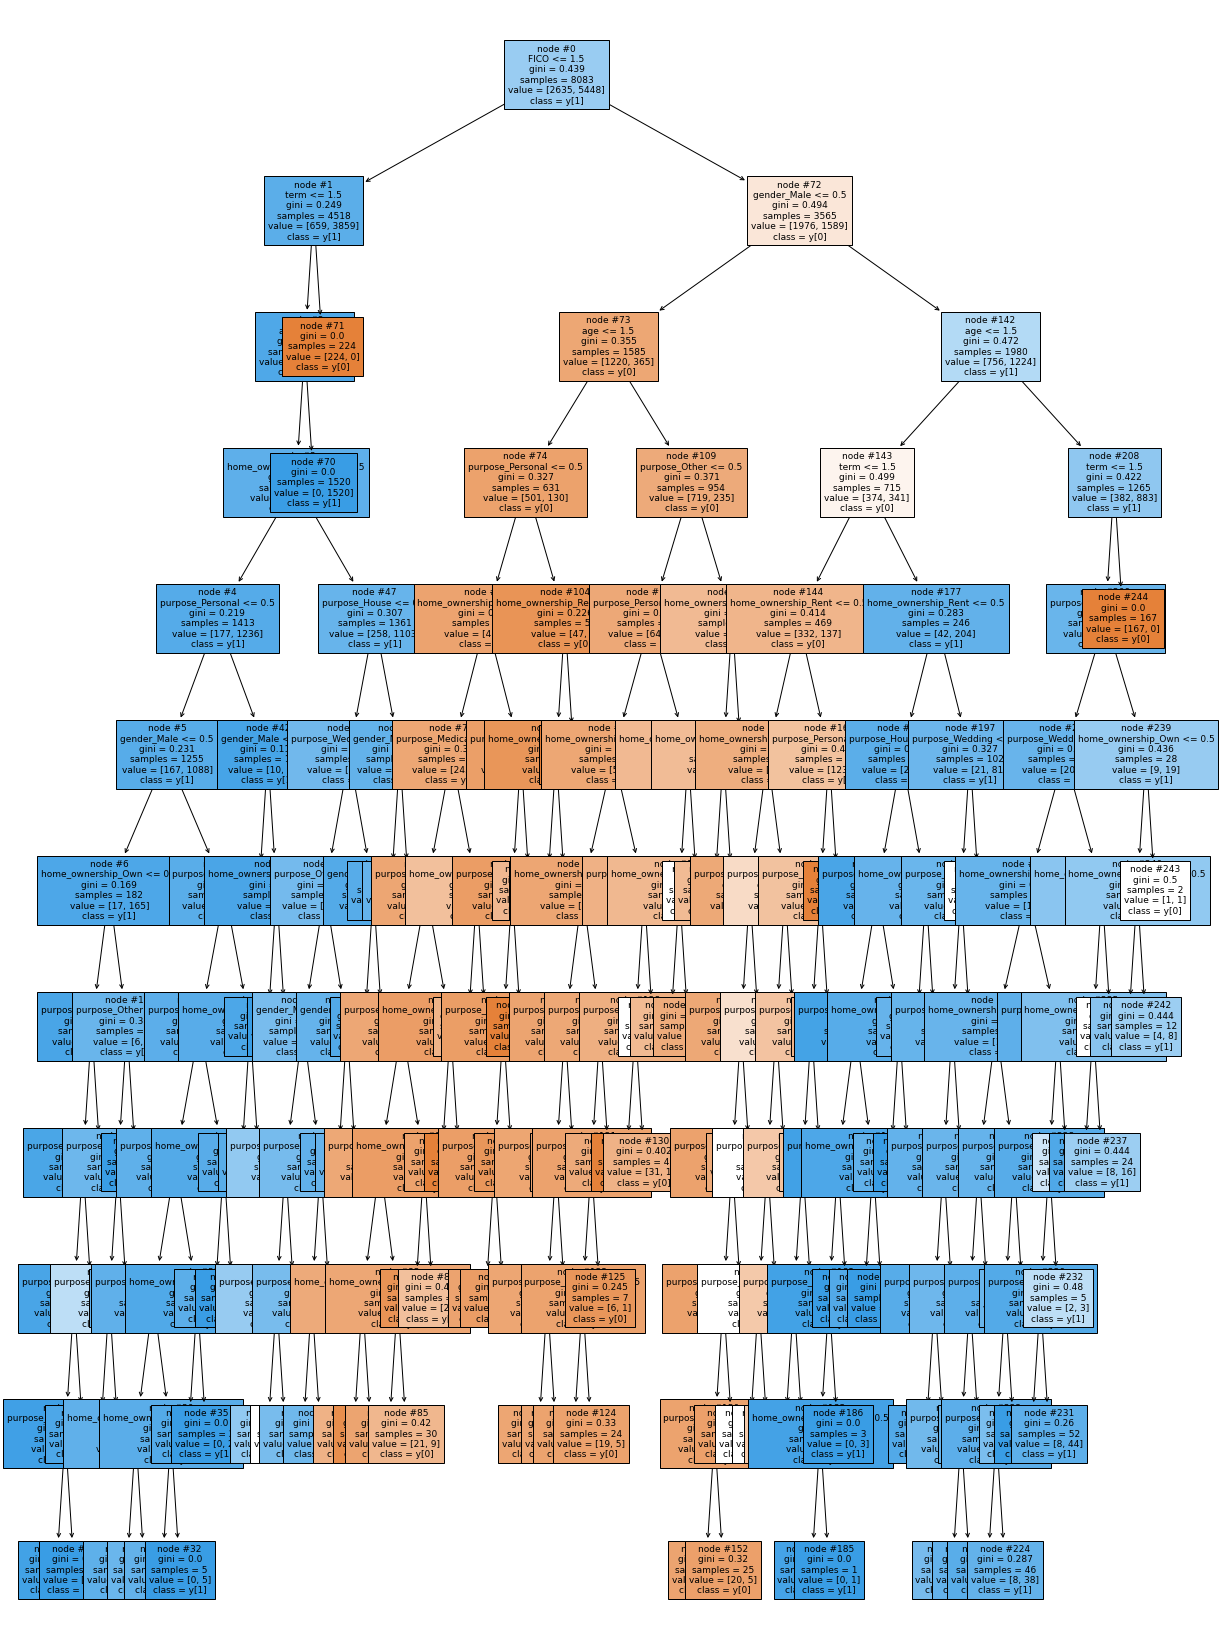

In [50]:
feature_names=list(X_new.columns)
plt.figure(figsize=(20,30))
tree.plot_tree(dt,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [51]:
print (pd.DataFrame(dt.feature_importances_, columns = ["Imp"], index = x_tra.columns).sort_values(by = 'Imp', ascending = False))

                          Imp
FICO                 0.393915
term                 0.370052
gender_Male          0.158036
age                  0.055813
home_ownership_Rent  0.005443
home_ownership_Own   0.004200
purpose_Personal     0.003300
purpose_House        0.003034
purpose_Other        0.002362
purpose_Medical      0.001998
purpose_Wedding      0.001848


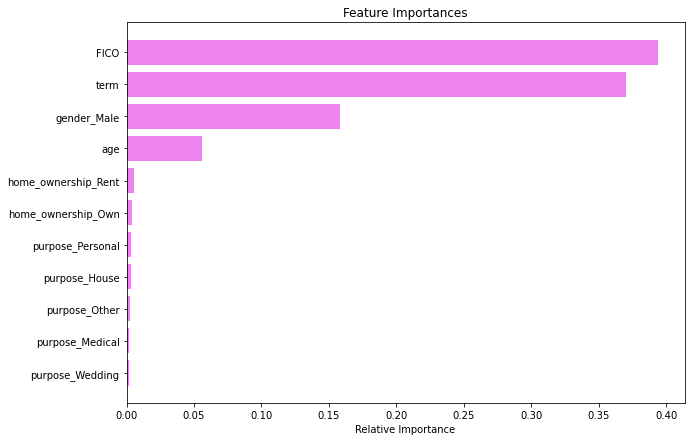

In [52]:
importances = dt.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='violet', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

* The decision tree is not overfitting because the scores for both training and testing data are almost equal.
* But still the hyperparameters can be tuned to improve the model performance.
* The FICO score is given the highest feature importance, followed by term of the loan.

### Using Gridsearch for hypertuning the parameter

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [54]:
# Choose the type of classifier. 
model = tree.DecisionTreeClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {'max_depth': np.arange(1,10), 
              'min_samples_leaf': [1, 2, 5, 7, 10,15,20],
              'max_leaf_nodes' : [2, 3, 5, 10],
              'min_impurity_decrease': [0.001,0.01,0.1]
             }

# Type of scoring used to compare parameter combinations
f_scorer = metrics.make_scorer(f1_score)

# Run the grid search
grid_obj = GridSearchCV(model, parameters, scoring=f_scorer,cv=5)
grid_obj = grid_obj.fit(x_tra, y_tra)

# Set the clf to the best combination of parameters
estimator = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
estimator.fit(x_tra, y_tra)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=10,
                       min_impurity_decrease=0.001, random_state=1)

In [55]:
model_performance(estimator,x_tra,y_tra)

,accuracy,recall,precision,f1_score
0,0.852283,0.907856,0.877261,0.892297


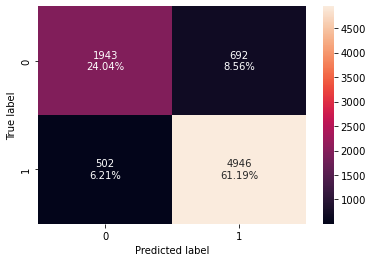

In [56]:
confusion_mat(estimator,x_tra,y_tra)

In [57]:
model_performance(estimator,x_tes,y_tes)

,accuracy,recall,precision,f1_score
0,0.847908,0.896172,0.875,0.88546


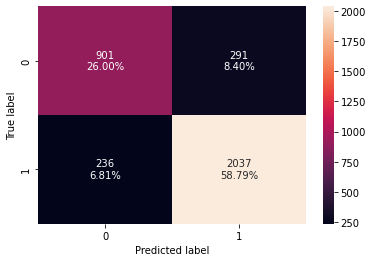

In [58]:
confusion_mat(estimator,x_tes,y_tes)

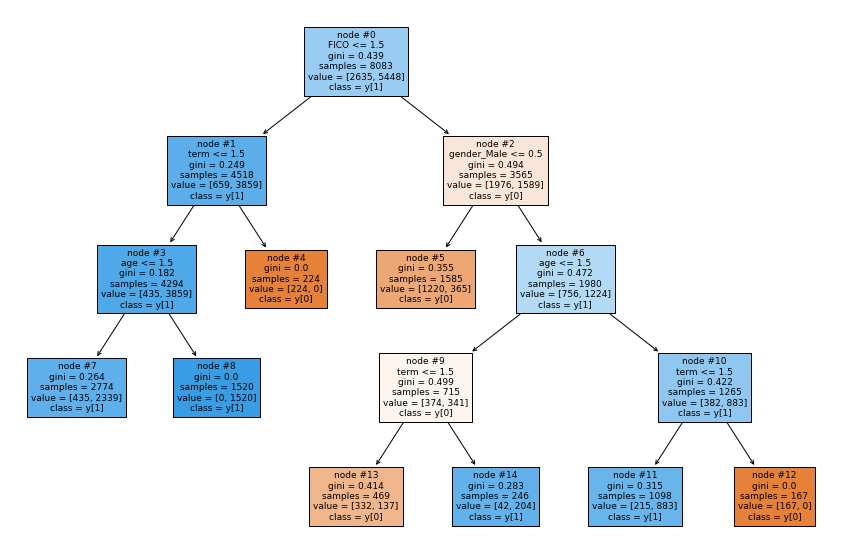

In [59]:
plt.figure(figsize=(15,10))

tree.plot_tree(estimator,feature_names=feature_names,filled=True,fontsize=9,node_ids=True,class_names=True)
plt.show()

In [60]:
# Text report showing the rules of a decision tree -

print(tree.export_text(estimator,feature_names=feature_names,show_weights=True))

|--- FICO <= 1.50
|   |--- term <= 1.50
|   |   |--- age <= 1.50
|   |   |   |--- weights: [435.00, 2339.00] class: 1
|   |   |--- age >  1.50
|   |   |   |--- weights: [0.00, 1520.00] class: 1
|   |--- term >  1.50
|   |   |--- weights: [224.00, 0.00] class: 0
|--- FICO >  1.50
|   |--- gender_Male <= 0.50
|   |   |--- weights: [1220.00, 365.00] class: 0
|   |--- gender_Male >  0.50
|   |   |--- age <= 1.50
|   |   |   |--- term <= 1.50
|   |   |   |   |--- weights: [332.00, 137.00] class: 0
|   |   |   |--- term >  1.50
|   |   |   |   |--- weights: [42.00, 204.00] class: 1
|   |   |--- age >  1.50
|   |   |   |--- term <= 1.50
|   |   |   |   |--- weights: [215.00, 883.00] class: 1
|   |   |   |--- term >  1.50
|   |   |   |   |--- weights: [167.00, 0.00] class: 0



In [61]:
print (pd.DataFrame(estimator.feature_importances_, columns = ["Imp"], index = x_tra.columns).sort_values(by = 'Imp', ascending = False))

                          Imp
FICO                 0.403592
term                 0.379142
gender_Male          0.160832
age                  0.056435
purpose_House        0.000000
purpose_Medical      0.000000
purpose_Other        0.000000
purpose_Personal     0.000000
purpose_Wedding      0.000000
home_ownership_Own   0.000000
home_ownership_Rent  0.000000


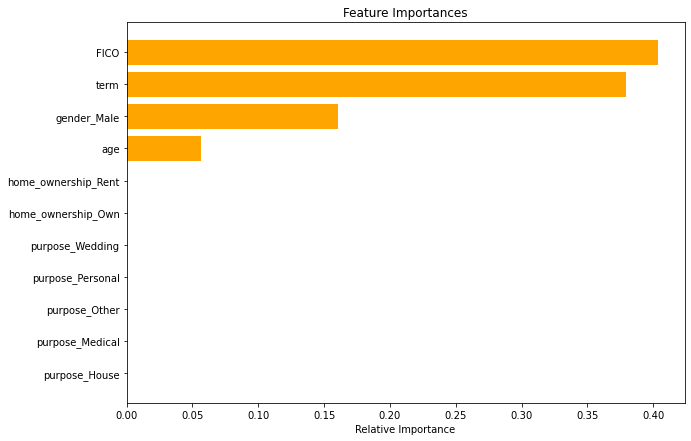

In [62]:
importances = estimator.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,7))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='orange', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Conclusion

* FICO, term and gender are the most important factors in differentiating if a customer will be a delinquent or not in that order.
* No borrower will be given loan when the FICO score ranges between 300-500 and the loan term is 36 months.
* IF the FICO score is less than 500 and the duration of loan is less than 60 months then there is a high chance that the customer falls into delinuent category.
* Similarly when the gender is female and the FICO score is greater than 500 then there is a high chance that they will fall into non-delinquent category.